#  End-to-End Car Price Prediction: Polynomial Features, Ridge Regression, GridSearchCV, and Streamlit Deployment



This notebook demonstrates a complete workflow to:
- Select important features
- Engineer polynomial features
- Apply Ridge Regression with hyperparameter tuning
- Evaluate model performance
- Prepare the model for deployment using Streamlit


1.Load all required libraries for data analysis, modeling, and hyperparameter tuning.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

## 2. Check R² Scores for Individual Features

This helper function loops through all features (except `"three"`), fits a simple model for each single feature, and plots their individual training & test R² scores.

This helps to:
- Understand which features have the highest predictive power alone.
- Compare training vs. test performance for each feature.
- Spot overfitting if training R² is much higher than test R².

The bar plot shows the R² for each feature. The printed output shows mean & max R² across all features.

In [ ]:
def get_R2_features(model,test=True):
    #X: global
    features=list(X)
    features.remove("three")

    R_2_train=[]
    R_2_test=[]

    for feature in features:
        model.fit(X_train[[feature]],y_train)

        R_2_test.append(model.score(X_test[[feature]],y_test))
        R_2_train.append(model.score(X_train[[feature]],y_train))

    plt.bar(features,R_2_train,label="Train")
    plt.bar(features,R_2_test,label="Test")
    plt.xticks(rotation=90)
    plt.ylabel("$R^2$")
    plt.legend()
    plt.show()
    print("Training R^2 mean value {} Testing R^2 mean value {} ".format(str(np.mean(R_2_train)),str(np.mean(R_2_test))) )
    print("Training R^2 max value {} Testing R^2 max value {} ".format(str(np.max(R_2_train)),str(np.max(R_2_test))) )

This helper function visualizes the **absolute coefficients** of the trained regression model.

**What it shows:**
- The bigger the bar, the more influence that feature has on the prediction.
- Helps interpret which features the model relies on most.
- The function skips the first two columns (`X.columns[2:]`).

It also prints the **training and testing R² scores** to quickly check model performance.

In [ ]:
def plot_coef(X,model,name=None):


    plt.bar(X.columns[2:],abs(model.coef_[2:]))
    plt.xticks(rotation=90)
    plt.ylabel("$coefficients$")
    plt.title(name)
    plt.show()
    print("R^2 on training  data ",model.score(X_train, y_train))
    print("R^2 on testing data ",model.score(X_test,y_test))


This helper function compares the distribution of **actual** vs. **predicted** target values using overlapping KDE plots.

**What it shows:**
- If the predicted curve matches the actual curve closely, the model fits well.
- Useful to visually check if the model underfits or overfits certain ranges.



In [ ]:
def  plot_dis(y,yhat):

    plt.figure()
    ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)
    plt.legend()

    plt.title('Actual vs Fitted Values')
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

## 3. Load Data & Train Basic Linear Regression

- Load the encoded car dataset.
- Fit a simple **Linear Regression** model on the training data.
- Predict on the test data.
- Print the **R² scores** to check model performance on training and testing sets.


In [ ]:
data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/encoded_car_data.csv')
data.head()

,diesel,gas,std,turbo,convertible,hardtop,hatchback,sedan,wagon,4wd,...,wheelbase,curbweight,enginesize,boreratio,horsepower,carlength,carwidth,citympg,highwaympg,price
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,13495.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,16500.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,94.5,2823.0,152.0,2.68,154.0,171.2,65.5,19.0,26.0,16500.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,99.8,2337.0,109.0,3.19,102.0,176.6,66.2,24.0,30.0,13950.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,99.4,2824.0,136.0,3.19,115.0,176.6,66.4,18.0,22.0,17450.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   diesel       205 non-null    float64
 1   gas          205 non-null    float64
 2   std          205 non-null    float64
 3   turbo        205 non-null    float64
 4   convertible  205 non-null    float64
 5   hardtop      205 non-null    float64
 6   hatchback    205 non-null    float64
 7   sedan        205 non-null    float64
 8   wagon        205 non-null    float64
 9   4wd          205 non-null    float64
 10  fwd          205 non-null    float64
 11  rwd          205 non-null    float64
 12  dohc         205 non-null    float64
 13  dohcv        205 non-null    float64
 14  l            205 non-null    float64
 15  ohc          205 non-null    float64
 16  ohcf         205 non-null    float64
 17  ohcv         205 non-null    float64
 18  rotor        205 non-null    float64
 19  eight   

In [ ]:
X = data.drop('price', axis=1)
y = data.price

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
print("number of test samples :", X_test.shape[0])
print("number of training samples:",X_train.shape[0])

number of test samples : 21
number of training samples: 184


In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)
predicted = lm.predict(X_test)
print("R^2 on training  data ",lm.score(X_train, y_train))
print("R^2 on testing data ",lm.score(X_test,y_test))

R^2 on training  data  0.9092101381197337
R^2 on testing data  0.9472499250323804


/tmp/ipython-input-24-4156269868.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
/tmp/ipython-input-24-4156269868.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , a

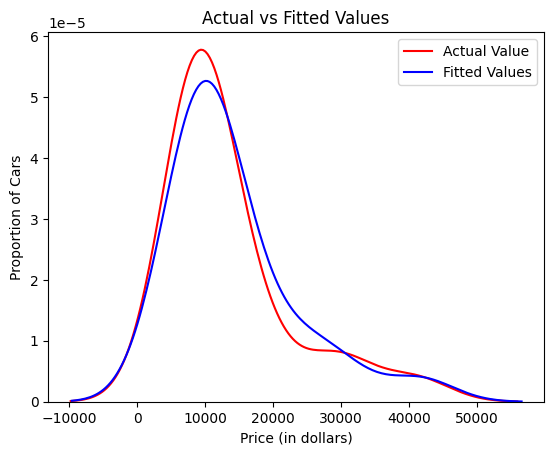

In [ ]:
plot_dis(y_test,predicted)

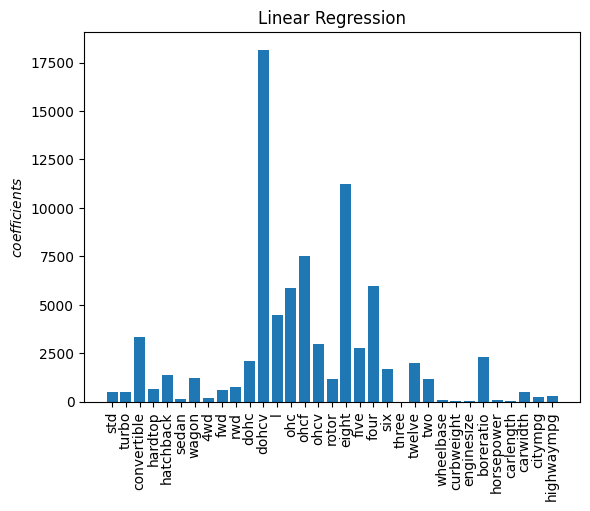

R^2 on training  data  0.9092101381197337
R^2 on testing data  0.9472499250323804


In [ ]:
plot_coef(X,lm,name="Linear Regression")

- Train a **Ridge Regression** model (`alpha = 0.01`) to add L2 regularization.
- Predict on the test data.
- Print the **R² scores** to compare performance with basic Linear Regression.

In [ ]:
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train)
predicted_rr=rr.predict(X_test)
print("R^2 on training  data ",rr.score(X_train, y_train))
print("R^2 on testing data ",rr.score(X_test,y_test))

R^2 on training  data  0.9091956531801181
R^2 on testing data  0.947878461559649


/tmp/ipython-input-24-4156269868.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
/tmp/ipython-input-24-4156269868.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(yhat, hist=False, color="b", label="Fitted Values" , a

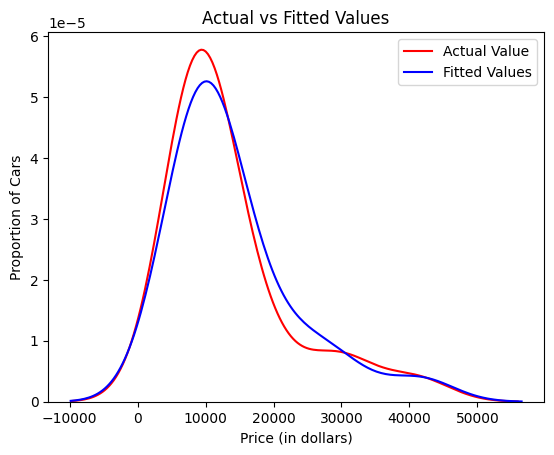

In [ ]:
plot_dis(y_test,predicted_rr)

## 📌 Train with Selected Important Features & Hyperparameter Tuning

- Keep only the **manually selected important features** (based on domain  model coefficients).
- Build a pipeline with:
   - Polynomial feature generation
   - Standard scaling
   - Ridge Regression
- Fit the pipeline and check performance.
- Use **GridSearchCV** to tune the **polynomial degree** and **regularization strength (`alpha`)** for the best model on the selected features.


In [ ]:
important_features = ['dohcv', 'ohc', 'rotor', 'four', 'eight',
                      'enginesize', 'curbweight', 'wheelbase']

X_train = X_train[important_features]
X_test = X_test[important_features]


In [ ]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),('ss',StandardScaler() ), ('model',Ridge(alpha=1))]
pipe = Pipeline(Input)
pipe.fit(X_train, y_train)
predicted=pipe.predict(X_test)
pipe.score(X_test, y_test)

0.9219456902239247

In [ ]:
param_grid = {
    "polynomial__degree": [1,2,3,4],
    "model__alpha":[0.0001,0.001,0.01,0.1,1,10]
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)

search.fit(X_train, y_train)
search

GridSearchCV(estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(include_bias=False)),
                                       ('ss', StandardScaler()),
                                       ('model', Ridge(alpha=1))]),
             n_jobs=2,
             param_grid={'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'polynomial__degree': [1, 2, 3, 4]})

In [ ]:
print("best_score_: ",search.best_score_)
print("best_params_: ",search.best_params_)

best_score_:  0.7794507740429808
best_params_:  {'model__alpha': 10, 'polynomial__degree': 2}


In [ ]:
best = search.best_estimator_
print(best.score(X_test, y_test))

0.9277005444567559


In [ ]:
X_small = X[important_features]

In [ ]:
X_small

,dohcv,ohc,rotor,four,eight,enginesize,curbweight,wheelbase
0,0.0,0.0,0.0,1.0,0.0,130.0,2548.0,88.6
1,0.0,0.0,0.0,1.0,0.0,130.0,2548.0,88.6
2,0.0,0.0,0.0,0.0,0.0,152.0,2823.0,94.5
3,0.0,1.0,0.0,1.0,0.0,109.0,2337.0,99.8
4,0.0,1.0,0.0,0.0,0.0,136.0,2824.0,99.4
...,...,...,...,...,...,...,...,...
200,0.0,1.0,0.0,1.0,0.0,141.0,2952.0,109.1
201,0.0,1.0,0.0,1.0,0.0,141.0,3049.0,109.1
202,0.0,0.0,0.0,0.0,0.0,173.0,3012.0,109.1
203,0.0,1.0,0.0,0.0,0.0,145.0,3217.0,109.1


In [ ]:
best.fit(X_small,y)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('ss', StandardScaler()), ('model', Ridge(alpha=10))])

In [ ]:
import joblib
joblib.dump(best, "final.pkl")


['final.pkl']

In [ ]:
from google.colab import files
files.download('final.pkl')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_small

,dohcv,ohc,rotor,four,eight,enginesize,curbweight,wheelbase
0,0.0,0.0,0.0,1.0,0.0,130.0,2548.0,88.6
1,0.0,0.0,0.0,1.0,0.0,130.0,2548.0,88.6
2,0.0,0.0,0.0,0.0,0.0,152.0,2823.0,94.5
3,0.0,1.0,0.0,1.0,0.0,109.0,2337.0,99.8
4,0.0,1.0,0.0,0.0,0.0,136.0,2824.0,99.4
...,...,...,...,...,...,...,...,...
200,0.0,1.0,0.0,1.0,0.0,141.0,2952.0,109.1
201,0.0,1.0,0.0,1.0,0.0,141.0,3049.0,109.1
202,0.0,0.0,0.0,0.0,0.0,173.0,3012.0,109.1
203,0.0,1.0,0.0,0.0,0.0,145.0,3217.0,109.1
